In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
#Connect to database

import mysql.connector
import time
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password",
  database="valorant_tracker"
)
cursor = mydb.cursor() 

In [6]:
df = pd.read_sql("SELECT * FROM stats", mydb)
print("Number of samples: " + str(df.shape[0]))

Number of samples: 1486070


In [7]:
df['user_id'] = df['match_player_id'].str[36:]


In [8]:
print(df.columns)

Index(['match_player_id', 'rounds', 'date', 'result', 'map', 'smurf', 'agent',
       'kills', 'headshots', 'deaths', 'assists', 'damage', 'damage_received',
       'econ_rating', 'plants', 'defuses', 'first_bloods', 'grenade_casts',
       'ability_2_casts', 'ability_1_casts', 'ultimate_casts', 'placement',
       'kdratio', 'headshot_percentage', 'first_deaths', 'last_deaths',
       'current_rank', 'user_id'],
      dtype='object')


In [9]:
import matplotlib.pyplot as plt

data = df.drop(["match_player_id", 
"user_id", 
"date", 
"rounds", 
"map", 
"result", 
"agent",
"smurf",
"current_rank",], axis=1)

#Should eventually take into account ability casts for each agent
data = data.drop(["grenade_casts",
"ability_2_casts",
"ability_1_casts",
"ultimate_casts"
], axis=1)


kills


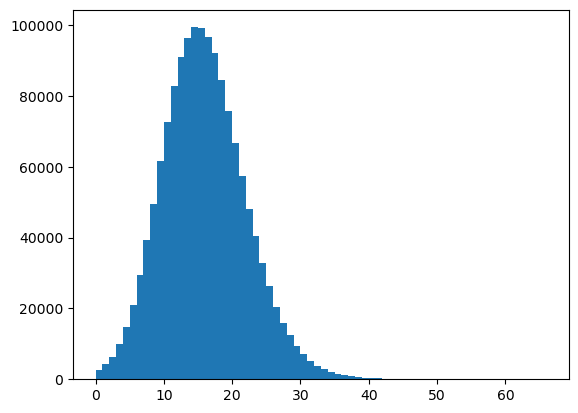

headshots


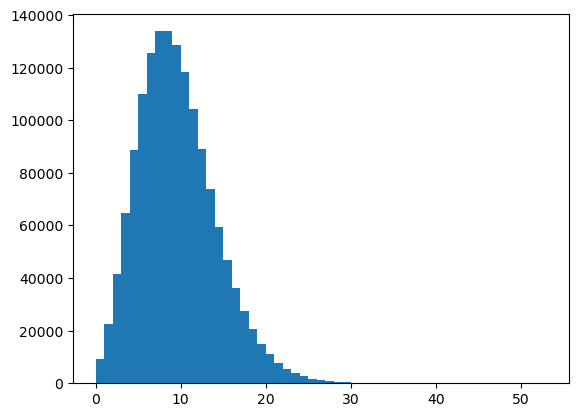

deaths


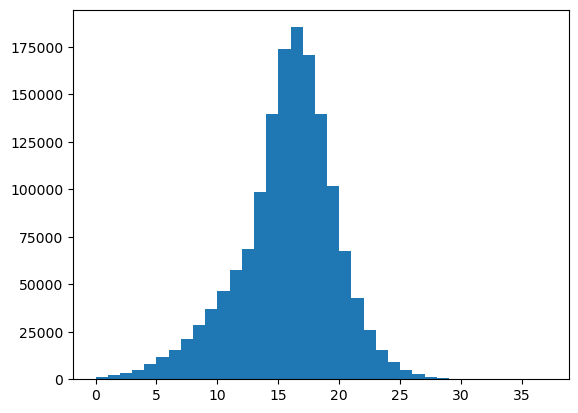

assists


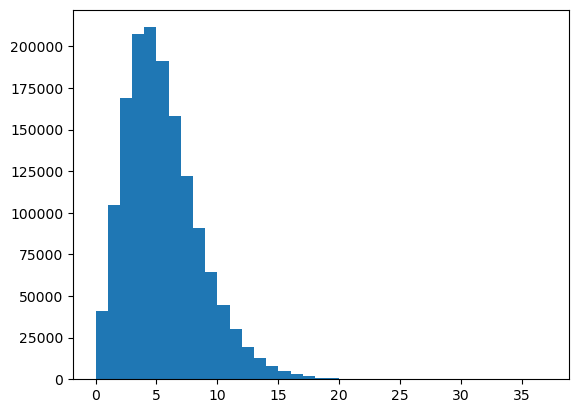

damage


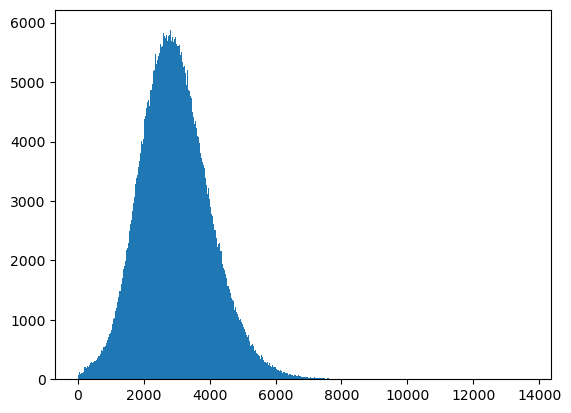

damage_received


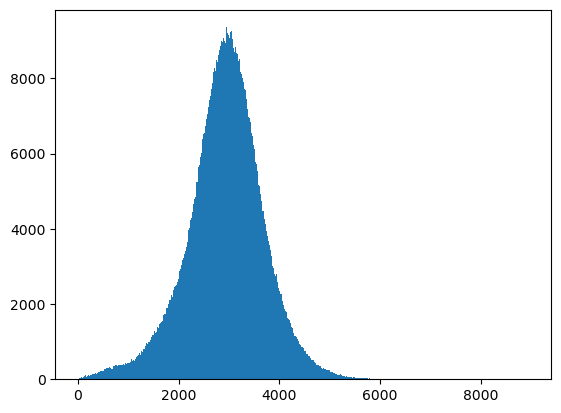

econ_rating


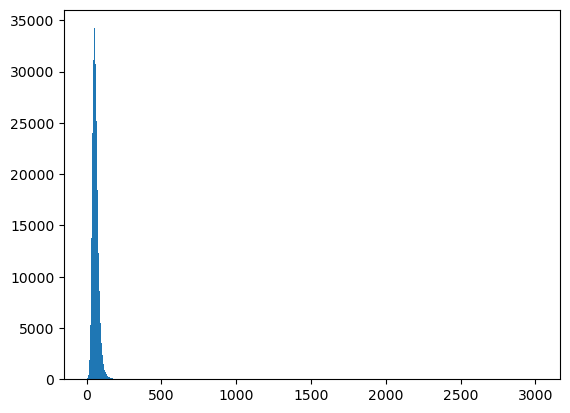

plants


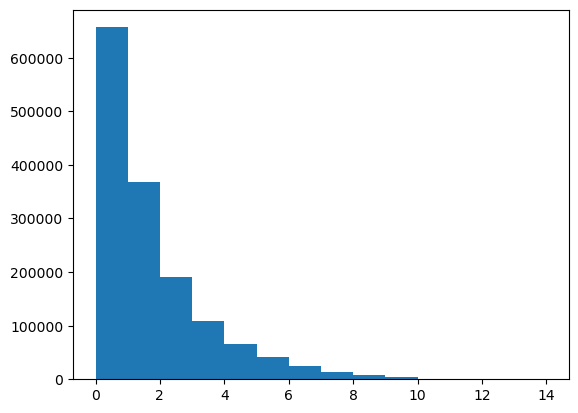

defuses


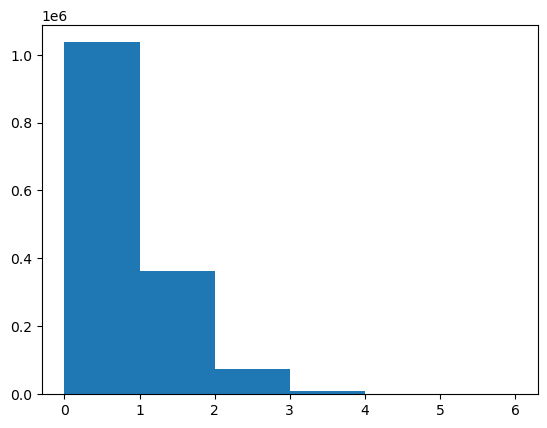

first_bloods


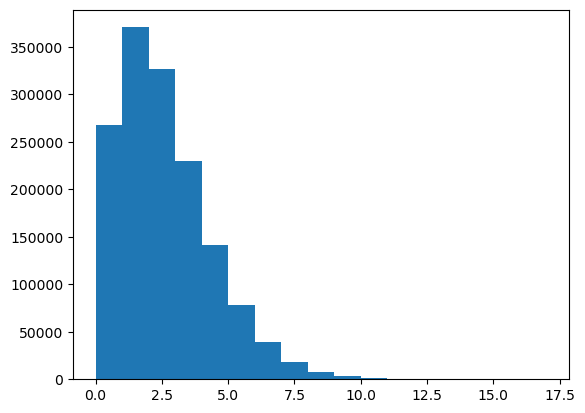

placement


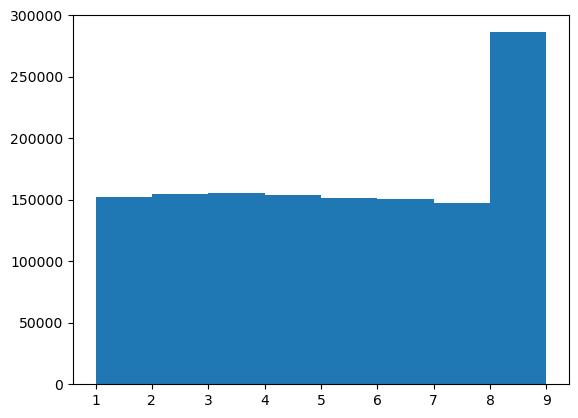

kdratio


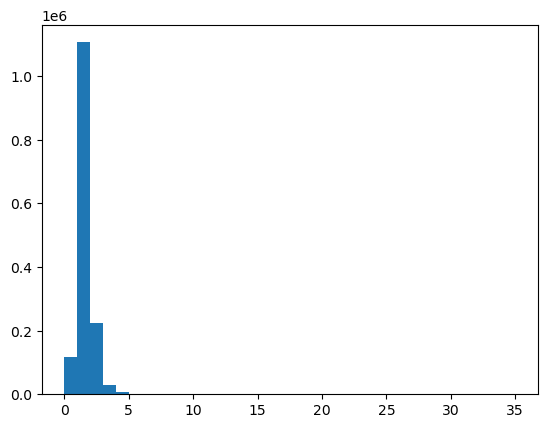

headshot_percentage


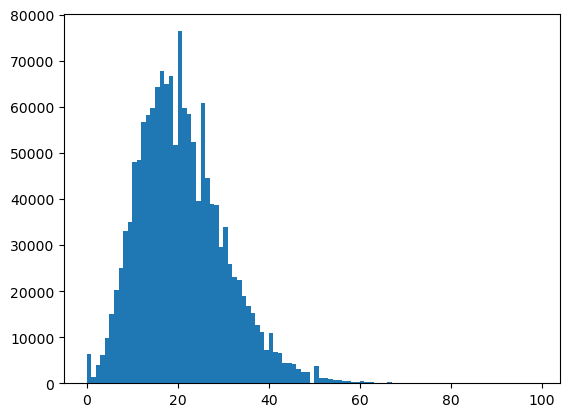

first_deaths


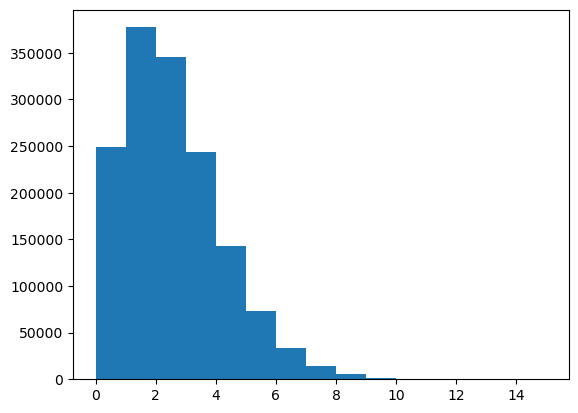

last_deaths


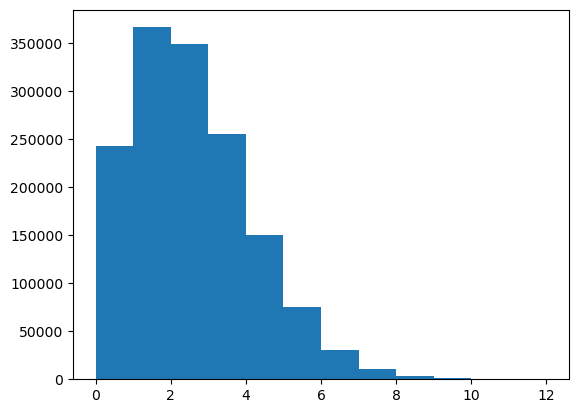

In [10]:
for col in data:
    print(col)
    bin_size = 10 if col == "damage" or col == "damage_received" else 1
    plt.hist(data[col], bins=np.arange(df[col].min(), df[col].max(), bin_size))
    plt.show()

(array([242788., 971837., 270315.,   1130.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <BarContainer object of 12 artists>)

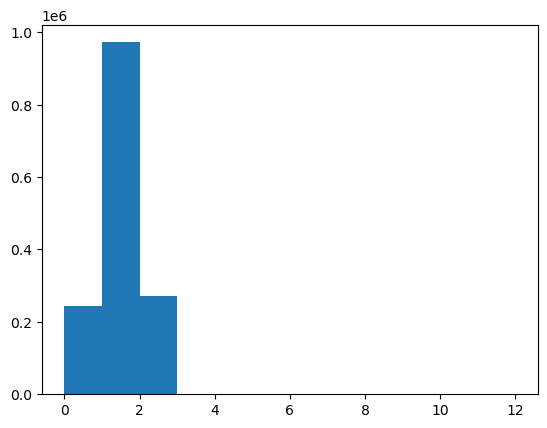

In [11]:

plt.hist(data["last_deaths"] ** 0.5, bins=np.arange(df["last_deaths"].min(), df["last_deaths"].max(), 1))

(array([2.48709e+05, 9.67254e+05, 2.67278e+05, 2.82700e+03, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <BarContainer object of 12 artists>)

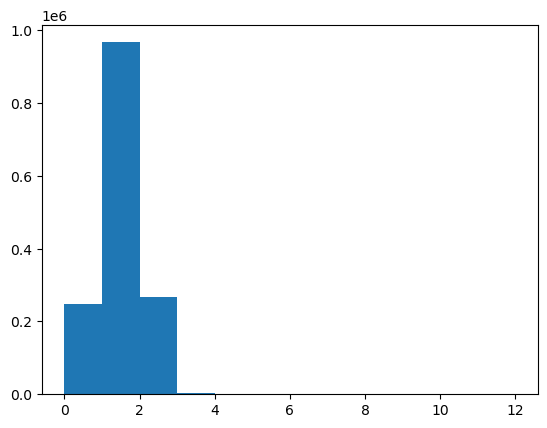

In [12]:

plt.hist(data["first_deaths"] ** 0.5, bins=np.arange(df[col].min(), df[col].max(), 1))

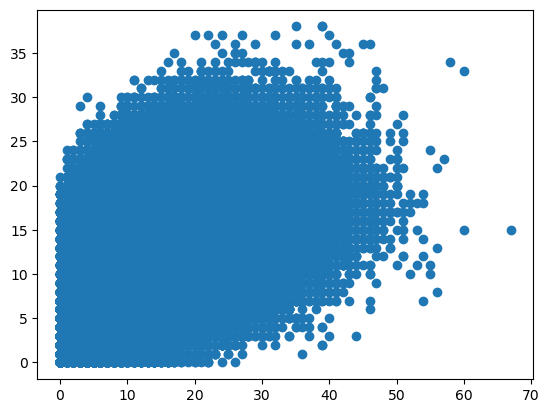

In [13]:
plt.scatter(df["kills"], df["deaths"])

In [14]:
data = df[["kills", "deaths", "user_id"]]

In [21]:
avg_data = data.groupby("user_id").mean()

In [22]:
avg_data

,kills,deaths
user_id,,
000#Angel,16.066667,14.663333
01000101#NA1,14.596667,15.190000
0ClF#519,15.400000,14.930000
0Sanchez0#4845,14.620000,16.366667
0hwin#3712,17.663333,15.863333
...,...,...
Ｌｉｍｐ Ｄｉｃｋ Ｌａｒｒｙ#6969,14.346667,12.406667
ＳＫＩＺＭ#999,18.223333,15.683333
Ｓｗｉｚｚｙ#iwnll,18.805556,14.481481


In [80]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    ### START CODE HERE ### 
    
    mu = np.sum(X, axis=0)/m
    var = np.sum((X-mu)**2, axis=0)/m
    
    ### END CODE HERE ### 
        
    return mu, var

def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    
    X1, X2 = np.meshgrid(np.arange(-2, 33, 0.5), np.arange(7, 24, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 4, 3)), linewidths=1)
        

def multivariate_gaussian(X, mu, var):   
    k = len(mu)   
    if var.ndim == 1:
        var = np.diag(var)       
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p


In [81]:
mu, var = estimate_gaussian(avg_data.to_numpy())      

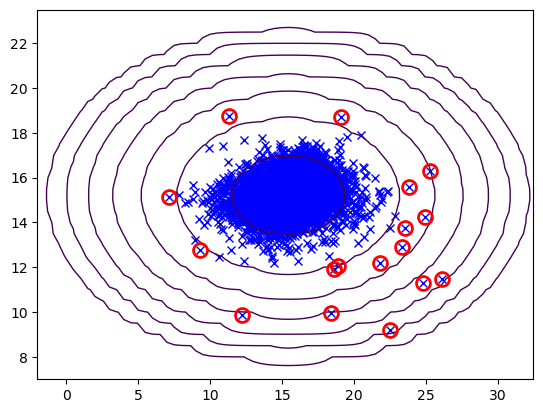

In [110]:
p = multivariate_gaussian(avg_data.to_numpy(), mu, var)
outliers = p < 0.000005

visualize_fit(avg_data.to_numpy(), mu, var)

plt.plot(avg_data.to_numpy()[outliers, 0], avg_data.to_numpy()[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

No validation set or test set being used to find optimal epsilon (should consider doing that, however, 0.000001 seems to work fairly well). After checking the accounts below, some of them appear to have two different users. One plays extremely well and the other plays poorly.

In [111]:
avg_data[outliers]

,kills,deaths
user_id,,
2006 Ford F250#beep,9.333333,12.769231
Billy#Bob,18.394231,9.971154
Blade#3091,11.350000,18.750000
Cringe#1578,12.217949,9.858974
Cwammycwam79#nerds,21.850000,12.200000
EBoy#3690,22.500000,9.214286
Envied#Insta,24.800000,11.285714
GBCxSellout#HBK,19.100000,18.700000
Hayolansoluye#7779,26.125000,11.458333


In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(avg_data, test_size=0.2)

In [25]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators = 100, random_state=0).fit(train)


In [26]:
anomaly = clf.predict(test)


In [27]:
test_anomaly = test
test_anomaly["anomaly"] = anomaly.tolist()


In [83]:
anomalies = test_anomaly[(test_anomaly["anomaly"] == -1)]

In [84]:
anomalies.shape[0]

206

In [99]:
anom_true = anomalies[(anomalies["anomaly"] == -1)]


In [100]:
anom_true

,kills,deaths,anomaly
user_id,,,
ThatonegirlJoeY#9212,11.933333,13.946667,-1
J O B O#jojoo,11.006667,15.256667,-1
Bradmpoke#8888,10.045226,15.035176,-1
KobyFPS#7704,16.303333,16.713333,-1
Rosh80#7977,17.690000,16.243333,-1
...,...,...,...
i miss her ツ#SUS,18.996667,15.853333,-1
skar#let,11.592391,14.347826,-1
donworryeatcurry#curry,18.133333,16.080000,-1


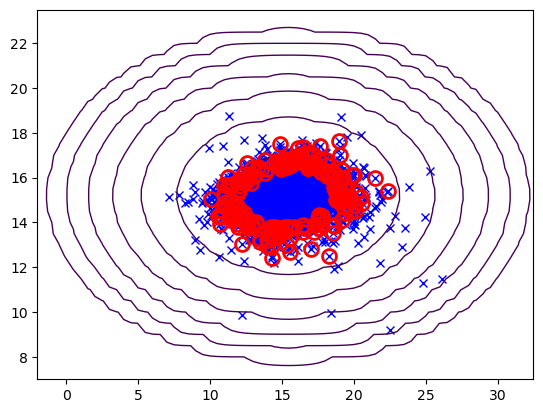

In [101]:
visualize_fit(avg_data.to_numpy(), mu, var)
plt.plot(anom_true["kills"].to_numpy(), anom_true["deaths"].to_numpy(), 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

In [85]:
anomalies

,kills,deaths,anomaly
user_id,,,
ThatonegirlJoeY#9212,11.933333,13.946667,-1
J O B O#jojoo,11.006667,15.256667,-1
Bradmpoke#8888,10.045226,15.035176,-1
KobyFPS#7704,16.303333,16.713333,-1
Rosh80#7977,17.690000,16.243333,-1
...,...,...,...
i miss her ツ#SUS,18.996667,15.853333,-1
skar#let,11.592391,14.347826,-1
donworryeatcurry#curry,18.133333,16.080000,-1
